<br>  

## <span style='color:blue'>Section 1: Import</span>  

In [1]:
import pandas as pd
import numpy as np
import copy

from sklearn.model_selection import StratifiedKFold

from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter

from imblearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier

import shap
shap.initjs()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

<br>  

## <span style='color:blue'>Section 2: Read, drop columns, form X_train and y_train</span>  

In [2]:
# ---------- read ----------

df_1 = pd.read_csv('../data/code_3_train.csv')

# ---------- drop ----------

print('Before drop :', df_1.shape)
df_1.drop(columns=['index',
                   'pco2', 'ph', 'basophils', 'lactic_acid', 'bmi',
                   'creatine_kinase', 'lymphocyte', 'neutrophils'], inplace=True)
print('After drop:', df_1.shape)
print('')

# ---------- form X ----------

X_train = df_1.drop(columns=['outcome'])
print('X_train :', X_train.shape)

# ---------- form y ----------

y_train = df_1['outcome']
print('y_train :', y_train.shape)
print('')
print('y_train :', np.unique(y_train, return_counts=True))
print('y_train :', Counter(y_train))
print(y_train.value_counts(normalize=True))

Before drop : (882, 51)
After drop: (882, 42)

X_train : (882, 41)
y_train : (882,)

y_train : (array([0., 1.]), array([763, 119], dtype=int64))
y_train : Counter({0.0: 763, 1.0: 119})
0.0    0.865079
1.0    0.134921
Name: outcome, dtype: float64


<br>  

## <span style='color:blue'>Section 3: Pipeline instantiate, fit, predict - Full train set</span>  

In [3]:
# ---------- instantiate ----------

pipe_line_kn = Pipeline([('knn_impute', KNNImputer(n_neighbors=5)),
                         ('oversample_SMOTE', SMOTE(random_state=42)),
                         ('ss_scale', StandardScaler()),
                         ('kn_class', KNeighborsClassifier())])

pipe_line_kn.set_params(oversample_SMOTE__sampling_strategy=1.00,
                        kn_class__n_neighbors=1000,
                        kn_class__weights='uniform',
                        kn_class__algorithm='brute',
                        kn_class__p=2)

# ---------- fit ----------

pipe_line_kn.fit(X_train, y_train)

# ---------- predict ----------

y_train_predicted = pipe_line_kn.predict(X_train)

<br>  

## <span style='color:blue'>Section 4: Model summary using SHAP</span>  

In [4]:
# ---------- select a sample from X_train to feed into SHAP ----------

X_train_sample = shap.utils.sample(X_train, nsamples=100, random_state=42)
explainer = shap.KernelExplainer(pipe_line_kn.predict, X_train_sample)

In [5]:
shap_values_sample = explainer.shap_values(X_train_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

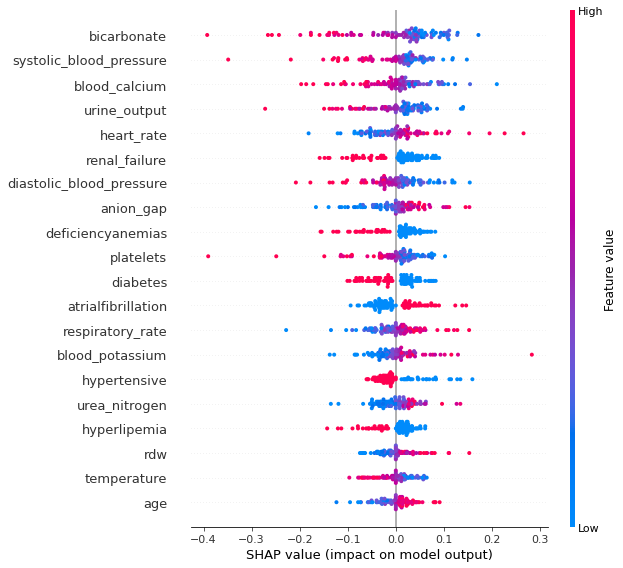

In [6]:
# ---------- class ----------

shap.summary_plot(shap_values_sample, X_train_sample)

<br>  

## <span style='color:blue'>Section 5: Read, drop columns, form X_test and y_test</span>  

In [7]:
# ---------- read ----------

df_2 = pd.read_csv('../data/code_3_test.csv')

# ---------- drop ----------

print('Before drop :', df_2.shape)
df_2.drop(columns=['index',
                   'pco2', 'ph', 'basophils', 'lactic_acid', 'bmi',
                   'creatine_kinase', 'lymphocyte', 'neutrophils'], inplace=True)
print('After drop:', df_2.shape)
print('')

# ---------- form X ----------

X_test = df_2.drop(columns=['outcome'])
print('X_test :', X_test.shape)

# ---------- form y ----------

y_test = df_2['outcome']
print('y_test :', y_test.shape)
print('')
print('y_test :', np.unique(y_test, return_counts=True))
print('y_test :', Counter(y_test))
print(y_test.value_counts(normalize=True))

Before drop : (294, 51)
After drop: (294, 42)

X_test : (294, 41)
y_test : (294,)

y_test : (array([0., 1.]), array([254,  40], dtype=int64))
y_test : Counter({0.0: 254, 1.0: 40})
0.0    0.863946
1.0    0.136054
Name: outcome, dtype: float64


<br>  

## <span style='color:blue'>Section 6: Pipeline predict - Full test set</span>  

In [8]:
y_test_predicted = pipe_line_kn.predict(X_test)

<br>  

## <span style='color:blue'>Section 7: Evaluate</span>  

In [9]:
# ---------- accuracy, recall, precision, overfit evaluation ----------

print('Train accuracy :', accuracy_score(y_train, y_train_predicted))
print('Test accuracy :', accuracy_score(y_test, y_test_predicted))
print('Overfit % = ( Test - Train ) / Train % :',
      (accuracy_score(y_test, y_test_predicted)-accuracy_score(y_train, y_train_predicted))/accuracy_score(y_train, y_train_predicted)*100)
print('')

print('Train recall :', recall_score(y_train, y_train_predicted))
print('Test recall :', recall_score(y_test, y_test_predicted))
print('Overfit % = ( Test - Train ) / Train % :',
      (recall_score(y_test, y_test_predicted)-recall_score(y_train, y_train_predicted))/recall_score(y_train, y_train_predicted)*100)
print('')

print('Train precision :', precision_score(y_train, y_train_predicted))
print('Test precision :', precision_score(y_test, y_test_predicted))
print('Overfit % = ( Test - Train ) / Train % :',
      (precision_score(y_test, y_test_predicted)-precision_score(y_train, y_train_predicted))/precision_score(y_train, y_train_predicted)*100)
print('')

Train accuracy : 0.3798185941043084
Test accuracy : 0.3741496598639456
Overfit % = ( Test - Train ) / Train % : -1.4925373134328326

Train recall : 0.9327731092436975
Test recall : 0.95
Overfit % = ( Test - Train ) / Train % : 1.8468468468468402

Train precision : 0.17076923076923076
Test precision : 0.17272727272727273
Overfit % = ( Test - Train ) / Train % : 1.1466011466011554



In [10]:
# ---------- confusion matrix calculation ----------

tn, fp, fn, tp = confusion_matrix(y_test, y_test_predicted).ravel()
print('True positive (dead): ', tp)
print('True negative (alive): ', tn)
print('False positive (dead): ', fp)
print('False negative (alive): ', fn)
print('')

print('Accuracy :', accuracy_score(y_test, y_test_predicted))
print('')

print('Sensitivity or Recall :', recall_score(y_test, y_test_predicted))
print('')

print('Precision or Positive Predictive Value :', precision_score(y_test, y_test_predicted))
print('')

print('Specificity :', tn/(tn+fp))
print('')

print('Negative predictive value :', tn/(tn+fn))

True positive (dead):  38
True negative (alive):  72
False positive (dead):  182
False negative (alive):  2

Accuracy : 0.3741496598639456

Sensitivity or Recall : 0.95

Precision or Positive Predictive Value : 0.17272727272727273

Specificity : 0.28346456692913385

Negative predictive value : 0.972972972972973


Text(69.0, 0.5, 'predicted')

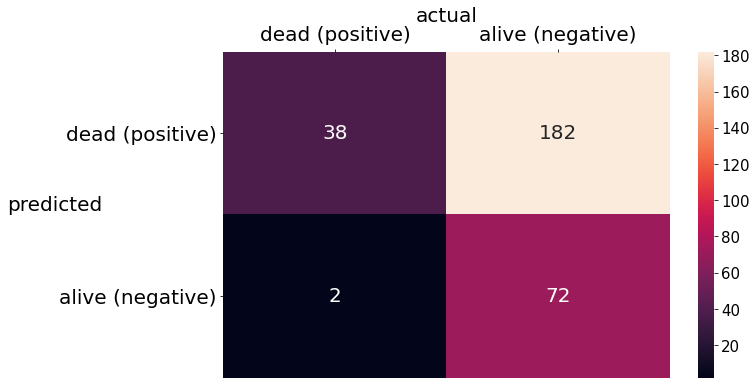

In [11]:
# ---------- confusion matrix visualisation ----------

temp_df = [[tp, fp], [fn, tn]]
temp_df = pd.DataFrame(temp_df, columns=['dead (positive)', 'alive (negative)'], index=['dead (positive)', 'alive (negative)'])
temp_df

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(temp_df, annot=True, fmt='d', annot_kws={'size': 20})

# Colour map labels

fig.axes[-1].tick_params(labelsize=15)

# X axis title

ax.tick_params(axis='x', labelrotation=0, which='major', labelsize=20, top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_label_position('top')
ax.set_xlabel('actual', {'fontsize': 20})

# Y axis title

ax.tick_params(axis='y', labelrotation=0, which='major', labelsize=20, left=True, labelleft=True)
ax.set_ylabel('predicted', {'fontsize': 20, 'rotation': 'horizontal'})


Area Under Curve (AUC) : 0.7597933070866142



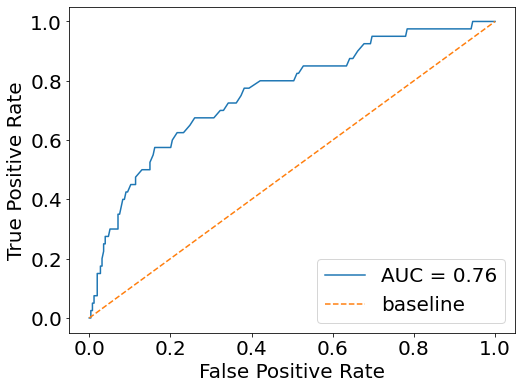

In [12]:
# ---------- area under receiver operating characteristic curve ----------

y_test_predicted_prob = pipe_line_kn.predict_proba(X_test)[:,1]

plt.figure(figsize=(8, 6))

fpr, tpr, _ = roc_curve(y_test, y_test_predicted_prob, drop_intermediate=False)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 3)))
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
plt.legend(loc='lower right', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.tick_params(labelsize=20)
print('')

print('Area Under Curve (AUC) :', roc_auc_score(y_test, y_test_predicted_prob))
print('')


Area Under Curve (AUC) : 0.34256201335228664



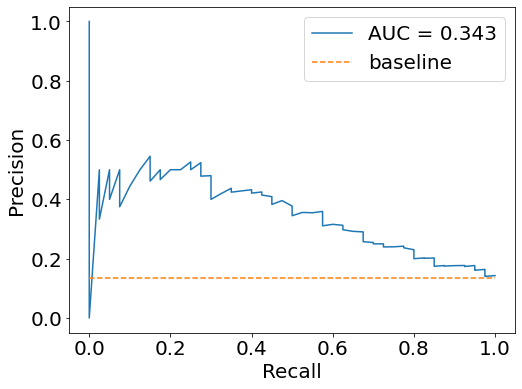

In [13]:
# ---------- area under precision recall curve ----------

y_test_predicted_prob = pipe_line_kn.predict_proba(X_test)[:,1]

plt.figure(figsize=(8, 6))

preci, recal, _ = precision_recall_curve(y_test, y_test_predicted_prob)
pr_auc = auc(recal, preci)

plt.plot(recal, preci, label='AUC = ' + str(round(pr_auc, 3)))
base_line = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [base_line, base_line], label='baseline', linestyle='--')
plt.legend(loc='upper right', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.xlabel('Recall', fontsize=20)
plt.tick_params(labelsize=20)
print('')

print('Area Under Curve (AUC) :', auc(recal, preci))
print('')

### <span style='color:green'>Final performance of K Nearest Neighbours Classifier:</span>  
* <span style='color:green'>Recall=0.950 (overfit=1.85%)</span>  
* <span style='color:green'>Precision=0.173 (overfit=1.15%) (Low precision expected as recall is more important)</span>  
* <span style='color:green'>AUROC=0.760</span>  
* <span style='color:green'>AUPRC=0.343</span>  

3 Jan 2022